In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# VEST UT 2016

## VEST Documentation

### Election Results

#### Sources

Election results from OpenElections.

#### Candidates

G16PRERTRU - Donald J. Trump (Republican Party)  
G16PREDCLI - Hillary Rodham Clinton (Democratic Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
G16PREISTE - Jill Stein (Unaffiliated)  
G16PREIMCM - Evan McMullen (Unaffiliated)  
G16PREOOTH - Other candidates on ballot  

G16USSRLEE - Mike Lee (Republican Party)  
G16USSDSNO - Misty K. Snow (Democratic Party)  
G16USSAFON - Stoney Fonua (Independent American Party)  
G16USSIBAR - Bill Barron (Unaffiliated)  

G16GOVRHER - Gary R. Herbert (Republican Party)  
G16GOVDWEI - Mike Weinholtz (Democratic Party)  
G16GOVLKAM - Brian E. Kamerath (Libertarian Party)  
G16GOVASCH - Superdell Schanze (Independent American Party)  

G16ATGRREY - Sean D. Reyes (Republican Party)  
G16ATGDHAR - Jon V. Harper (Democratic Party)  
G16ATGLMCC - W. Andrew McCullogh (Libertarian Party)  
G16ATGAISB - Michael W. IsBell (Independent American Party)  
    
G16AUDRDOU - John Rougall (Republican Party)  
G16AUDDMIT - Mike Mitchell (Democratic Party)  
G16AUDAGRE - Jared Green (Independent American Party)  

G16TRERDAM - David Damschen (Republican Party)  
G16TREDHAN - Neil A. Hansen (Democratic Party)  
G16TRECPRO - Richard Proctor (Constitution Party)  

#### Processing

Shapefile from the Utah Geographic Reference Center (https://gis.utah.gov/data/political/voter-precincts/).

The shapefile from the UGRC is of subprecincts, breaking down precincts in cases of district splits. In some cases, results are reported at the subprecinct level, in most cases, they weren't, so merging was done where necessary.

### Election Results Processing

#### Load in the VEST file

In [2]:
vest_ut_16 = gp.read_file("raw-from-source/VEST/ut_2016/ut_2016.shp")

In [3]:
vest_ut_16

,CountyID,PrecinctID,county,precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREISTE,G16PREIMCM,G16PREOOTH,...,G16ATGDHAR,G16ATGLMCC,G16ATGAISB,G16AUDRDOU,G16AUDDMIT,G16AUDAGRE,G16TRERDAM,G16TREDHAN,G16TRECPRO,geometry
0,1,BV01,Beaver,Beaver 1,469,46,6,1,83,3,...,48,18,17,481,69,27,454,80,36,"POLYGON ((358362.560 4238423.840, 358372.350 4..."
1,1,BV02,Beaver,Beaver 2,334,38,4,4,74,4,...,48,25,14,345,72,21,329,90,19,"POLYGON ((355866.750 4240506.080, 356860.230 4..."
2,1,BV03,Beaver,Beaver 3,268,22,3,0,49,2,...,31,6,11,269,44,14,254,52,18,"POLYGON ((358902.400 4261055.000, 358909.700 4..."
3,1,BV04,Beaver,Beaver 4,101,10,3,0,23,0,...,16,9,3,92,23,12,94,19,14,"POLYGON ((367866.500 4262536.100, 367842.500 4..."
4,1,GR01,Beaver,Greenville,76,10,0,2,4,0,...,12,0,0,67,16,0,57,20,5,"POLYGON ((348977.460 4223848.220, 348973.090 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,7,RO81,Duchesne,RO81,216,9,2,1,18,0,...,10,15,3,216,16,8,198,14,28,"POLYGON ((580836.220 4464060.720, 580837.220 4..."
2292,7,RO82,Duchesne,RO82,75,15,2,0,13,1,...,16,6,0,72,24,4,70,21,10,"POLYGON ((586967.910 4461063.280, 586317.330 4..."
2293,7,RO91,Duchesne,RO91,0,0,0,0,2,1,...,0,0,0,3,0,0,2,0,1,"POLYGON ((583252.560 4462118.640, 583274.150 4..."
2294,7,TA11,Duchesne,TA11,197,12,3,0,17,0,...,17,4,6,175,30,11,173,26,17,"POLYGON ((533169.000 4511919.160, 533169.000 4..."


In [4]:
data_columns = [x for x in vest_ut_16.columns if "G16" in x]

## Election Results

### Load, Clean, Pivot Election Results

#### Load in the OpenElections general election results for 2016 at precinct level

Load in individual counties' election data 

In [5]:
file_list = os.listdir("./raw-from-source/Open_Elections/counties/")
li = []
for file in file_list:
    #print(file)
    if "general" in file:
        #print(file)
        file_ref = "./raw-from-source/Open_Elections/counties/"+file
        file_prev = pd.read_csv(file_ref)
        if 'precincts' in file_prev.columns:
            file_prev['precinct'] = file_prev['precincts']
     
        file_prev = file_prev[['county', 'precinct', 'office', 'district', 'party', 'candidate','votes']]
        li.append(file_prev)
county_df = pd.concat(li, axis=0, ignore_index=True)
display(county_df)

,county,precinct,office,district,party,candidate,votes
0,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Rocky De La Fuente,0.0
1,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Jill Stein,2.0
2,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Alyson Kennedy,0.0
3,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Libertarian,Gary Johnson,12.0
4,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Independent American,Rocky Giordani,0.0
...,...,...,...,...,...,...,...
97152,Salt Lake,SJD023,State House,52.0,Republican,John Knotwell,386.0
97153,Salt Lake,SJD025,State House,52.0,Republican,John Knotwell,377.0
97154,Salt Lake,SJD029,State House,52.0,Republican,John Knotwell,429.0
97155,Salt Lake,SWT001,State House,52.0,Republican,John Knotwell,266.0


In [6]:
#Isolate the races used by VEST
list_of_races = ['President', 'U.S. Senate', 'Governor', 'Attorney General', 'State Auditor', 'State Treasurer']
clean_df = county_df[county_df['office'].isin(list_of_races)]

# candidate_office column is used to create unique candidate pivot column
# in case of same last name candidates running for different positions
clean_df['candidate_office'] = clean_df['candidate'] + '/' + clean_df['office']

<ipython-input-6-72ea72cc242e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['candidate_office'] = clean_df['candidate'] + '/' + clean_df['office']


In [7]:
clean_df['candidate_office'].unique()

array(['Rocky De La Fuente/President', 'Jill Stein/President',
       'Alyson Kennedy/President', 'Gary Johnson/President',
       'Rocky Giordani/President', 'Donald Trump/President',
       'Darrell Castle/President', 'Hillary Clinton/President',
       'Monica Moorehead/President', 'Evan McMullin/President',
       'Write In/President', 'Misty Snow/U.S. Senate',
       'Bill Barron/U.S. Senate', 'Stoney Fonua/U.S. Senate',
       'Mike Lee/U.S. Senate', 'Gary Herbert/Governor',
       'Dell Schanze/Governor', 'Brian Kamerath/Governor',
       'Mike Weinholtz/Governor', 'Write In/Governor',
       'Michael Isbell/Attorney General', 'Jon Harper/Attorney General',
       'Sean Reyes/Attorney General',
       'W. Andrew McCullough/Attorney General',
       'John Dougall/State Auditor', 'Jared Green/State Auditor',
       'Mike Mitchell/State Auditor', 'Richard Proctor/State Treasurer',
       'Neil Hansen/State Treasurer', 'David Damschen/State Treasurer',
       'Fuente/President', 'Gi

In [8]:
#Create a column with the candidate and office
clean_df["candidate_office"] = np.where(clean_df["candidate_office"].isna(),clean_df["party"]+"/"+clean_df["office"],clean_df["candidate_office"])

<ipython-input-8-df3b874cf452>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["candidate_office"] = np.where(clean_df["candidate_office"].isna(),clean_df["party"]+"/"+clean_df["office"],clean_df["candidate_office"])


In [9]:
#Standardize those values
cand_dict = {
    
    'Donald Trump/President': 'G16PRERTRU', 
    'Republican/President': 'G16PRERTRU', 

    'Hillary Clinton/President': 'G16PREDCLI', 
    'Democratic/President': 'G16PREDCLI', 

    'Gary Johnson/President': 'G16PRELJOH',
    'Libertarian/President': 'G16PRELJOH', 
    
    'Jill Stein/President': 'G16PREISTE', 
    
    'Evan McMullin/President': 'G16PREIMCM', 


    'Rocky De La Fuente/President': 'G16PREOOTH', 
    'Alyson Kennedy/President': 'G16PREOOTH', 
    'Rocky Giordani/President': 'G16PREOOTH', 
    'Darrell Castle/President': 'G16PREOOTH', 
    'Monica Moorehead/President': 'G16PREOOTH', 
     
    'Fuente/President': 'G16PREOOTH', 
    'Giordani/President': 'G16PREOOTH', 
    'Stephen Park/President': 'G16PREOOTH', 
    'Limbaugh/President': 'G16PREOOTH',
    'Tony Valdivia/President': 'G16PREOOTH', 
    'Fox/President': 'G16PREOOTH',
    'Sheila Samm Tittle/President': 'G16PREOOTH', 
    'Buchnan/President': 'G16PREOOTH', 
    'Marshall Schoenke/President': 'G16PREOOTH', 
    'Janet Reid/President': 'G16PREOOTH', 
    'Burton/President': 'G16PREOOTH', 
    'Giordani,Rocky/President': 'G16PREOOTH',
    'Roque De La Fuente/President': 'G16PREOOTH', 
    'Darrell L. Castle/President': 'G16PREOOTH', 
    'Tony Valdiva/President': 'G16PREOOTH',
    "'Rocky' De La Fuente/President": 'G16PREOOTH', 
    'Giordani/Anderson/President': 'G16PREOOTH', 
    'Independent American/President': 'G16PREOOTH', 
    'Constitution/President': 'G16PREOOTH', 
    'Stephen Paul Parks/President': 'G16PREOOTH', 
    'Jamin Burton/President': 'G16PREOOTH', 
    'Robert Buchanan/President': 'G16PREOOTH', 
    'Cherunda Fox/President': 'G16PREOOTH', 
    'David Limbaugh/President': 'G16PREOOTH',
    'Write-ins/President': "drop",
    'Write-In/President': "drop",
    'Write In/President': "drop",
    'Laurence Kotlikoff/President': "drop",
    'Andrew Basiago/President': "drop", 
    'Emidio Soltyisk/President': "drop",
    'Tom Hoefling/President': "drop", 
    'Emidio Soltysik/President': "drop", 
    'Hoefling/President': "drop",
    'Dustin Baird/President': "drop",
    'Mike Smith/President': "drop",
    
    'Mike Lee/U.S. Senate': 'G16USSRLEE',
    'Republican/U.S. Senate': 'G16USSRLEE', 
    
    'Misty Snow/U.S. Senate': 'G16USSDSNO', 
    'Misty K. Snow/U.S. Senate': 'G16USSDSNO',
    'Democratic/U.S. Senate': 'G16USSDSNO', 

    'Stoney Fonua/U.S. Senate': 'G16USSAFON', 
    'Independent American/U.S. Senate': 'G16USSAFON', 

    'Bill Barron/U.S. Senate': 'G16USSIBAR', 

    'Gary Herbert/Governor': 'G16GOVRHER', 
    'Gary R. Herbert/Governor': 'G16GOVRHER', 
    'Gray Herbert/Governor': 'G16GOVRHER', 
    'Republican/Governor': 'G16GOVRHER', 
    'Herbert/Governor': 'G16GOVRHER', 

    'Mike Weinholtz/Governor': 'G16GOVDWEI', 
    'Democratic/Governor': 'G16GOVDWEI', 

    'Brian Kamerath/Governor': 'G16GOVLKAM', 
    'Brian E. Kamerath/Governor': 'G16GOVLKAM',
    'Libertarian/Governor': 'G16GOVLKAM', 

    'Dell Schanze/Governor': 'G16GOVASCH', 
    'Superdell Schanze/Governor': 'G16GOVASCH', 
    'Independent American/Governor': 'G16GOVASCH', 
    
    # no write-in race code was created for Governor
    'L.S. Brown/Governor': "drop", 
    'Write In/Governor': "drop", 
    'Write-In/Governor': "drop", 
    'Write-ins/Governor': "drop", 

    
    
    'Sean Reyes/Attorney General': 'G16ATGRREY', 
    'Sean D. Reyes/Attorney General': 'G16ATGRREY',
    'Republican/Attorney General': 'G16ATGRREY', 

    'Jon V. Harper/Attorney General': 'G16ATGDHAR', 
    'Jon Harper/Attorney General': 'G16ATGDHAR', 
    'Democratic/Attorney General': 'G16ATGDHAR', 

    'W. Andrew McCullough/Attorney General': 'G16ATGLMCC', 
    'Libertarian/Attorney General': 'G16ATGLMCC', 
    
    'Michael Isbell/Attorney General': 'G16ATGAISB', 
    'Michael W. Isbell/Attorney General': 'G16ATGAISB', 
    'Independent American/Attorney General': 'G16ATGAISB', 

    'John Dougall/State Auditor': 'G16AUDRDOU', 
    'Republican/State Auditor': 'G16AUDRDOU', 
    
    'Mike Mitchell/State Auditor': 'G16AUDDMIT', 
    'Democratic/State Auditor': 'G16AUDDMIT', 

    'Jared Green/State Auditor': 'G16AUDAGRE', 
    'Independent American/State Auditor': 'G16AUDAGRE', 
    
    # CHANGED
    'Green/State Auditor': 'G16AUDAGRE', 

    'David Damschen/State Treasurer': 'G16TRERDAM', 
    'Davad Damschen/State Treasurer': 'G16TRERDAM',
    'Republican/State Treasurer': 'G16TRERDAM',
    
    'Neil A. Hansen/State Treasurer': 'G16TREDHAN',
    'Neil Hansen/State Treasurer': 'G16TREDHAN', 
    'Hansen/State Treasurer': 'G16TREDHAN',
    'Democratic/State Treasurer': 'G16TREDHAN', 

    'Richard Proctor/State Treasurer': 'G16TRECPRO', 
    'Constitution/State Treasurer': 'G16TRECPRO'
}

In [10]:
#Slightly modify the spelling of one county to match VEST
county_rename_dict = {"San Pete":"Sanpete"}
clean_df["county"] = clean_df["county"].map(county_rename_dict).fillna(clean_df["county"])

#Define a pivot column
clean_df["pivot_col"]=clean_df["county"]+"-"+clean_df["precinct"]

#Apply the "candidate_office" changes from above
clean_df["candidate_office"] = clean_df["candidate_office"].map(cand_dict).fillna(clean_df["candidate_office"])

#Filter out the values to be dropped
clean_df = clean_df[clean_df["candidate_office"]!="drop"]

<ipython-input-10-f2dc3ed07c66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["county"] = clean_df["county"].map(county_rename_dict).fillna(clean_df["county"])
<ipython-input-10-f2dc3ed07c66>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["pivot_col"]=clean_df["county"]+"-"+clean_df["precinct"]
<ipython-input-10-f2dc3ed07c66>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [11]:
#Perform the pivot
pivoted_2016 = pd.pivot_table(clean_df,values=["votes"],index=["pivot_col"],columns=["candidate_office"],aggfunc="sum")

#Reset the index
pivoted_2016.reset_index(inplace=True,drop=False)

#Clean up the columns and the indices
pivoted_2016.columns = pivoted_2016.columns.droplevel(0)
pivoted_2016.rename(columns={"":"pivot_col"},inplace=True)

#Filter out a row with total votes
pivoted_2016 = pivoted_2016[pivoted_2016["pivot_col"]!="Salt Lake-Election Total"]

## Statewide Totals Check

In [12]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [13]:
statewide_totals_check(vest_ut_16,pivoted_2016,data_columns)

***Statewide Totals Check***
G16PRERTRU is equal 	VEST / RDH: 515231
G16PREDCLI is equal 	VEST / RDH: 310676
G16PRELJOH is equal 	VEST / RDH: 39608
G16PREISTE is equal 	VEST / RDH: 9438
G16PREIMCM has a difference of 351.0 votes
	VEST: 243690 votes
	SOURCES: 243339.0 votes
G16PREOOTH has a difference of -345.0 votes
	VEST: 12740 votes
	SOURCES: 13085.0 votes
G16USSRLEE has a difference of 1.0 votes
	VEST: 760241 votes
	SOURCES: 760240.0 votes
G16USSDSNO is equal 	VEST / RDH: 301860
G16USSAFON is equal 	VEST / RDH: 27340
G16USSIBAR is equal 	VEST / RDH: 26167
G16GOVRHER is equal 	VEST / RDH: 750850
G16GOVDWEI is equal 	VEST / RDH: 323349
G16GOVLKAM is equal 	VEST / RDH: 34827
G16GOVASCH is equal 	VEST / RDH: 15912
G16ATGRREY is equal 	VEST / RDH: 719064
G16ATGDHAR is equal 	VEST / RDH: 275571
G16ATGLMCC has a difference of 2.0 votes
	VEST: 73975 votes
	SOURCES: 73973.0 votes
G16ATGAISB is equal 	VEST / RDH: 30687
G16AUDRDOU is equal 	VEST / RDH: 679675
G16AUDDMIT is equal 	VEST / RDH: 3

In [14]:
#The below was used to check against the 
#vest_ut_16.groupby(["county"]).sum().to_csv("./ut_vest_totals.csv")

## County-by-County Check

In [15]:
#Create a county column
pivoted_2016["county"] = pivoted_2016["pivot_col"].apply(lambda x:x.split("-")[0])

In [16]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [17]:
county_totals_check(vest_ut_16,pivoted_2016,data_columns,"county",full_print=False)

***Countywide Totals Check***

G16PRERTRU is equal across all counties
G16PREDCLI is equal across all counties
G16PRELJOH is equal across all counties
G16PREISTE is equal across all counties
G16PREIMCM contains differences in these counties:
	Kane has a difference of 351.0 votes
		VEST: 352 votes
		SOURCES: 1.0 votes
G16PREOOTH contains differences in these counties:
	Cache has a difference of 8.0 votes
		VEST: 799 votes
		SOURCES: 791.0 votes
	Daggett has a difference of 2.0 votes
		VEST: 7 votes
		SOURCES: 5.0 votes
	Davis has a difference of -3.0 votes
		VEST: 1408 votes
		SOURCES: 1411.0 votes
	Kane has a difference of -352.0 votes
		VEST: 29 votes
		SOURCES: 381.0 votes
G16USSRLEE contains differences in these counties:
	Carbon has a difference of 1.0 votes
		VEST: 5607 votes
		SOURCES: 5606.0 votes
G16USSDSNO is equal across all counties
G16USSAFON is equal across all counties
G16USSIBAR is equal across all counties
G16GOVRHER is equal across all counties
G16GOVDWEI is equal acro

## Precinct-by-Precinct Check

Create a unique column by combining county num and precinct name

In [18]:
pivoted_2016["unique_ID"] = pivoted_2016["pivot_col"].str.upper()
vest_ut_16["unique_ID"] = vest_ut_16["county"].str.upper()+"-"+vest_ut_16["precinct"].str.upper()

pivoted_2016["unique_ID"].value_counts(dropna=False)
vest_ut_16["unique_ID"].value_counts(dropna=False)

NaN                         76
SALT LAKE-EMC003             1
WASATCH-COUNTY EAST 30.1     1
WEBER-OGD020                 1
DAVIS-CLINTON 2              1
                            ..
SALT LAKE-WVC027             1
WEBER-NOG06                  1
SALT LAKE-MUR019             1
SALT LAKE-MIL020             1
CACHE-LOGAN 13               1
Name: unique_ID, Length: 2221, dtype: int64

In [19]:
#In instances where the "unique_ID" is NaN, use the PrecinctID column, instead of precinct
vest_ut_16["unique_ID"] = np.where(vest_ut_16["unique_ID"].isna(),vest_ut_16["county"]+"-"+vest_ut_16["PrecinctID"],vest_ut_16["unique_ID"])

In [20]:
pivoted_2016["unique_ID"].value_counts(dropna=False)
vest_ut_16["unique_ID"].value_counts(dropna=False)

CACHE-PROVIDENCE 02    1
DUCHESNE-RO52          1
UTAH-PR12              1
Salt Lake-NRV063       1
SALT LAKE-SLC136       1
                      ..
UTAH-LE01S:UN          1
DUCHESNE-RO72          1
SEVIER-5 ELSINORE      1
SALT LAKE-MUR004       1
CACHE-LOGAN 13         1
Name: unique_ID, Length: 2296, dtype: int64

In [21]:
join_attempt_one = pd.merge(vest_ut_16,pivoted_2016,how="outer",on="unique_ID",indicator=True)
join_attempt_one["_merge"].value_counts()

# join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./vest_unjoined.csv")
# join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./source_unjoined.csv")

both          2219
left_only       77
right_only       5
Name: _merge, dtype: int64

In [22]:
#Make one ID change to increase joins
id_changes_dict = {"BOX ELDER-TREMONTON 04":"BOX ELDER-TREMENTON 04"}
pivoted_2016["unique_ID"] = pivoted_2016["unique_ID"].map(id_changes_dict).fillna(pivoted_2016["unique_ID"])

### Allocate the absentee votes

In [23]:
allocating = pivoted_2016[pivoted_2016["unique_ID"]=="EMERY-CANVAS"]
receiving = pivoted_2016[pivoted_2016["unique_ID"]!="EMERY-CANVAS"]

In [24]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [25]:
pivoted_2016 = allocate_absentee(receiving,allocating,data_columns,"county",allocating_to_all_empty_precs=False)

In [26]:
#Merge two precinct's election results that VEST has merged
for i in data_columns:
    pivoted_2016.loc[pivoted_2016["unique_ID"]=="UTAH-CH02",i]+=int(pivoted_2016.loc[pivoted_2016["unique_ID"]=="UTAH-CH02:UN",i])
    
pivoted_2016 = pivoted_2016[pivoted_2016["unique_ID"]!="UTAH-CH02:UN"]

In [27]:
join_attempt_two = pd.merge(vest_ut_16,pivoted_2016,how="outer",on="unique_ID",indicator=True)
join_attempt_two["_merge"].value_counts()

both          2220
left_only       76
right_only       2
Name: _merge, dtype: int64

In [28]:
#Confirm that the unjoined precincts contain zero votes
for i in data_columns:
    left_val = i+"_x"
    right_val = i+"_y"
    print(sum(join_attempt_two[join_attempt_two["_merge"]=="left_only"][left_val]))
    print(sum(join_attempt_two[join_attempt_two["_merge"]=="right_only"][right_val]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [29]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [30]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns,True,"unique_ID",print_level=0)

G16PREOOTH ............................................................CACHE-AMALGA (V) ....9  (S)....8 (D):    1
G16PREOOTH ............................................................CACHE-BENSON (V) ....8  (S)....5 (D):    3
G16PREOOTH .........................................................CACHE-CLARKSTON (V) ....5  (S)....4 (D):    1
G16PREOOTH ................................................CACHE-COLLEGE/YOUNG WARD (V) ....5  (S)...12 (D):   -7
G16PREOOTH ......................................................CACHE-HYDE PARK 02 (V) ....2  (S)...14 (D):  -12
G16PREOOTH ..........................................................CACHE-HYRUM 01 (V) ...13  (S)....7 (D):    6
G16PREOOTH ..........................................................CACHE-HYRUM 02 (V) ...14  (S)....3 (D):   11
G16PREOOTH ..........................................................CACHE-HYRUM 03 (V) ....7  (S)...22 (D):  -15
G16PREOOTH ..........................................................CACHE-HYRUM 04 (V) 

#### Look into the differences

CARBON-EAST CARBON looks like a typo, VEST correct

IRON-MODENA looks like a typo again. VEST correct

Kane County - McMullin and other votes switched, VEST correct

DAVIS-BOUNTIFUL 7, VEST looks wrong here

DAGGETT MANILA - VEST looks wrong here

CACHE - VEST looks wrong here, seems like they used the combined open elections file, which has some errors, whereas we used the combined file

#### Note: We informed Open Elections of these issues and will reach out to VEST once they are corrected there

## Shapefile Processing

In [31]:
ut_shapefile = gp.read_file("./raw-from-source/Shapefiles/Utah_Vista_Ballot_Areas/VistaBallotAreas.shp")

In [32]:
ut_shapefile = ut_shapefile.to_crs(vest_ut_16.crs)

<AxesSubplot:>

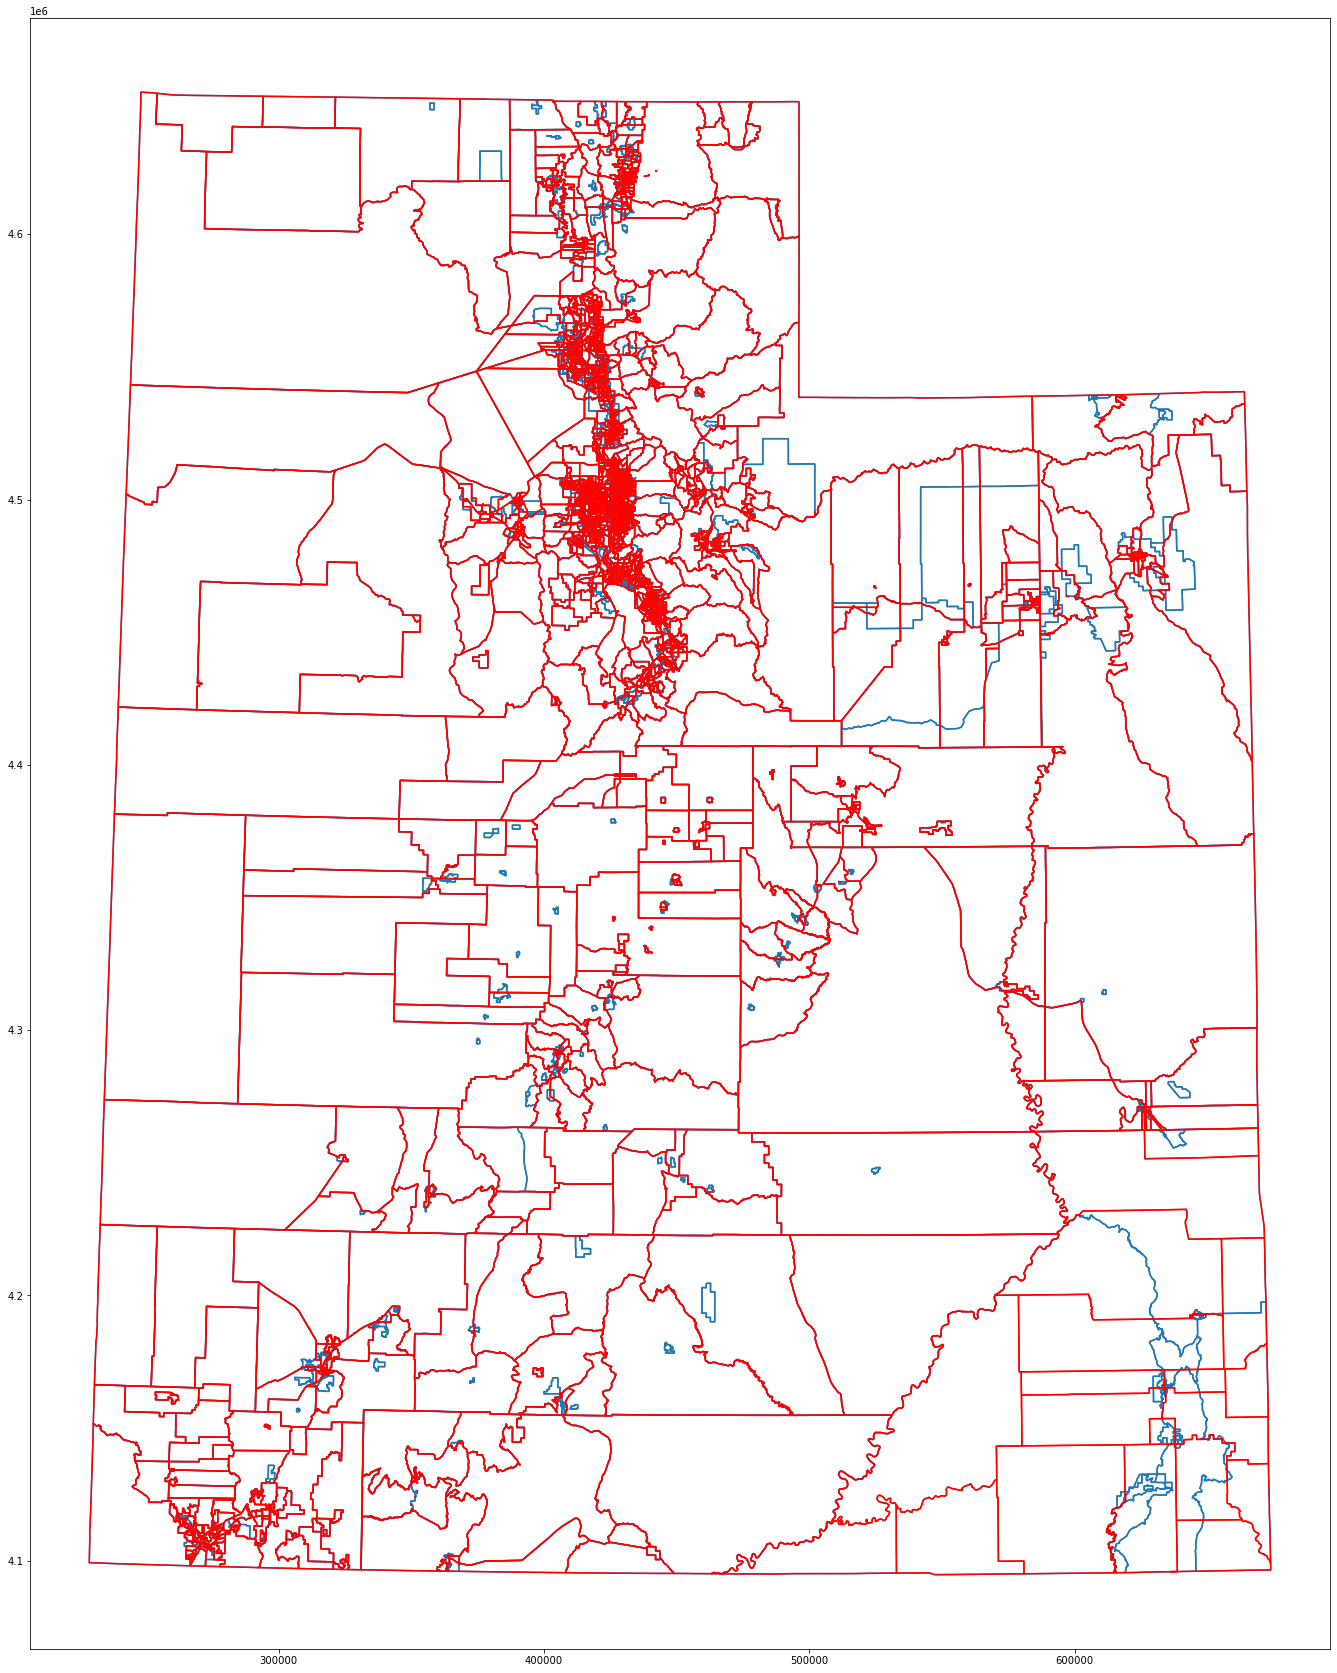

In [33]:
ax = ut_shapefile.boundary.plot(figsize=(30,30))
vest_ut_16.boundary.plot(ax=ax,color="red")

In [34]:
ut_shapefile

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{886D020D-51B9-48B5-A28D-CC764A5E0F82},0.195803,0.001577,"POLYGON ((442100.733 4105063.611, 442087.183 4..."
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{FFE08944-1D79-42D7-962E-AC71AD650996},0.044090,0.000095,"POLYGON ((440397.769 4462604.406, 440287.773 4..."
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{43BB406D-2A87-417B-81D7-C34BCDDD17DA},0.039456,0.000041,"POLYGON ((429513.757 4511318.890, 429560.510 4..."
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{9B6E24D8-8475-4BF1-BFA5-702BE7C1A5E4},2.571008,0.063659,"POLYGON ((298916.515 4118840.324, 298979.335 4..."
4,5,6,KA09:I-C-,KA09,I-C-,2013.12,None,None,GISMASTER,2021-02-10,{D45AF05A-8177-4286-9CEF-758E587CFA5D},0.039713,0.000036,"POLYGON ((423105.776 4544237.639, 423109.680 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,3062,6,WX01:U-S-,WX01,U-S-,2015.12,None,None,GISMASTER,2021-02-10,{9FE7FFD2-572E-4524-89F4-170C424E08EB},0.081443,0.000252,"POLYGON ((421650.530 4526719.559, 421648.887 4..."
3062,3063,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{A7FFD04B-9AFA-42A9-BD52-6E6617DFEFCF},0.036616,0.000062,"POLYGON ((421194.647 4499569.273, 421200.099 4..."
3063,3064,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{B0B47492-516F-4CB7-97E6-C2D3069FD2FA},0.060945,0.000100,"POLYGON ((431267.704 4507028.531, 431267.705 4..."
3064,3065,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{3F65B9EC-984A-4B2F-B34B-E8337B060AF0},0.045916,0.000078,"POLYGON ((433321.152 4493130.130, 433324.339 4..."


#### Note: As described in the report, from our other UT validation work, we know we won't be fully able to join UT data, much less tell if VEST made any errors, because UT does not keep older precinct shapefiles